In [1]:
# Import libraries for loading data, analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import join

# Load Review Data

Load and filter data for analysis/visualization

In [2]:
# This gets you to your code directory
path = Path.cwd()
# This gets you to your project directory
ROOT_DIR = path.parent.absolute()
# Root for data directory
r_fp = join(ROOT_DIR, 'data', 'processed')

In [4]:
# Read data
open_df = pd.read_csv(join(r_fp, 'articles_reviewed.csv'),
                      encoding='latin1')

In [4]:
# We're dropping articles from journals with samples that aren't
# large enough

# We're dropping articles 

In [11]:
open_df.head()

,authors,title,journal,doc_type,total_cited,doi,doi_link,pub_year,is_climate,dropped,...,data_open,code_open,data_repo,code_repo,data_included,data_limitation_other,code_included,data_reasons,code_reasons,notes
0,"Long, L; Wu, CY; Yang, Z; Tang, CYY",Carbon Nanotube Interlayer Enhances Water Perm...,ENVIRONMENTAL SCIENCE & TECHNOLOGY,Article,49,10.1021/acs.est.1c07332,http://dx.doi.org/10.1021/acs.est.1c07332,2022,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Song, KS; Fang, C; Jacinthe, PA; Wen, ZD; Liu,...",Climatic versus Anthropogenic Controls of Deca...,ENVIRONMENTAL SCIENCE & TECHNOLOGY,Article,47,10.1021/acs.est.0c06480,http://dx.doi.org/10.1021/acs.est.0c06480,2021,1.0,NaN,...,Closed,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Tang, HT; Zhang, S; Chen, WY",Assessing Representative CCUS Layouts for Chin...,ENVIRONMENTAL SCIENCE & TECHNOLOGY,Article,44,10.1021/acs.est.1c03401,http://dx.doi.org/10.1021/acs.est.1c03401,2021,1.0,NaN,...,Closed,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Zhu, JJ; Dressel, W; Pacion, K; Ren, ZYJ",ES&T in the 21st Century: A Data-Driven Analys...,ENVIRONMENTAL SCIENCE & TECHNOLOGY,Article,43,10.1021/acs.est.0c07551,http://dx.doi.org/10.1021/acs.est.0c07551,2021,1.0,NaN,...,Closed,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Jin, YL; Wang, LW; Song, YA; Zhu, J; Qin, MH; ...",Integrated Life Cycle Assessment for Sustainab...,ENVIRONMENTAL SCIENCE & TECHNOLOGY,Article,39,10.1021/acs.est.1c02535,http://dx.doi.org/10.1021/acs.est.1c02535,2021,1.0,NaN,...,Closed,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Summarize Review

Get summary statistics overall and by journal

In [5]:
# First, map issn to journal names
j_map = {'1758-678X': 'Nature Climate Change',
         '2398-9629': 'Nature Sustainability',
         '2542-5196': 'Lancet Planetary Health',
         '2590-3330': 'One Earth'}

open_f['journ'] = open_f['issn'].map(j_map)

/tmp/ipykernel_28848/4172577993.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_f['journ'] = open_f['issn'].map(j_map)


In [6]:
COLS = ['data_avail', 'data_some', 'code_avail', 'code_some']
print(open_f[COLS].describe())

       data_avail   data_some  code_avail   code_some
count  177.000000  177.000000  175.000000  175.000000
mean     0.158192    0.779661    0.131429    0.502857
std      0.365956    0.415651    0.338838    0.501427
min      0.000000    0.000000    0.000000    0.000000
25%      0.000000    1.000000    0.000000    0.000000
50%      0.000000    1.000000    0.000000    1.000000
75%      0.000000    1.000000    0.000000    1.000000
max      1.000000    1.000000    1.000000    1.000000


In [7]:
# Save num studies per journal
n_df = open_f.groupby('journ')[COLS].size()
print(n_df)

journ
Lancet Planetary Health    37
Nature Climate Change      47
Nature Sustainability      43
One Earth                  50
dtype: int64


In [8]:
print(open_f.groupby('journ')[COLS].mean())

                         data_avail  data_some  code_avail  code_some
journ                                                                
Lancet Planetary Health    0.054054   0.270270    0.027027   0.081081
Nature Climate Change      0.148936   0.872340    0.148936   0.723404
Nature Sustainability      0.116279   0.930233    0.142857   0.619048
One Earth                  0.280000   0.940000    0.183673   0.510204


In [9]:
# Store journal df for easier plotting later
plot_df = open_f.groupby('journ')[COLS].sum()
print(plot_df)

                         data_avail  data_some  code_avail  code_some
journ                                                                
Lancet Planetary Health         2.0       10.0         1.0        3.0
Nature Climate Change           7.0       41.0         7.0       34.0
Nature Sustainability           5.0       40.0         6.0       26.0
One Earth                      14.0       47.0         9.0       25.0


In [10]:
# Need to check how many null code entries there are
# This can happen if there is no code used. Need to subtract that
# from the initial closed count 
no_code = open_f['code_some'].isna().groupby(open_f['journ']).sum()
print(no_code)

journ
Lancet Planetary Health    0
Nature Climate Change      0
Nature Sustainability      1
One Earth                  1
Name: code_some, dtype: int64


In [101]:
# Get values for plotting
closed_data = []
some_data = []
complete_data = []
closed_code = []
some_code = []
complete_code = []

# The way entries are coded, we get the number of entries
# in closed, some, complete openness as follows
# Closed_Plot = Total - Some
# Some_Plot = Some - Complete
# Complete_Plot = Complete

# Loop through journals in order of % openness
for j_name in ['One Earth', 'Nature Climate Change',
               'Nature Sustainability', 'Lancet Planetary Health']:
    # For each journal, follow the pseudo code above to get values
    # Then add to the appropriate list
    
    # Complete data and code
    complete_data_t = plot_df.loc[j_name]['data_avail']
    complete_code_t = plot_df.loc[j_name]['code_avail']
    
    # Some data and code
    some_data_t = plot_df.loc[j_name]['data_some'] - complete_data_t
    some_code_t = plot_df.loc[j_name]['code_some'] - complete_code_t
    
    # Closed
    closed_data_t = n_df.loc[j_name] - plot_df.loc[j_name]['data_some']
    closed_code_t = n_df.loc[j_name] - plot_df.loc[j_name]['code_some']
    
    # Adjust closed by no code entries
    closed_code_f = closed_code_t - no_code.loc[j_name]

    # Append to lists
    closed_data.append(closed_data_t)
    closed_code.append(closed_code_f)
    some_data.append(some_data_t)
    some_code.append(some_code_t)
    complete_data.append(complete_data_t)
    complete_code.append(complete_code_t)

In [111]:
# We also want percentages
# Divide the number stored in each list by the total sample size

# Total numbers (taken from n_df but ordered by % open)
data_n = [50, 47, 43, 37]

# Numbers for code (subtract 1 for sust & one earth)
code_n = [49, 47, 42, 37]

# Percentages w/ data_n
closed_data_p = [100*closed_data[i]/data_n[i] for i in range(4)]
some_data_p = [100*some_data[i]/data_n[i] for i in range(4)]
complete_data_p = [100*complete_data[i]/data_n[i] for i in range(4)]

# Percentages w/ code_n
some_code_p = [100*some_code[i]/code_n[i] for i in range(4)]
closed_code_p = [100*closed_code[i]/code_n[i] for i in range(4)]
complete_code_p = [100*complete_code[i]/code_n[i] for i in range(4)]

Plot the journal-level results

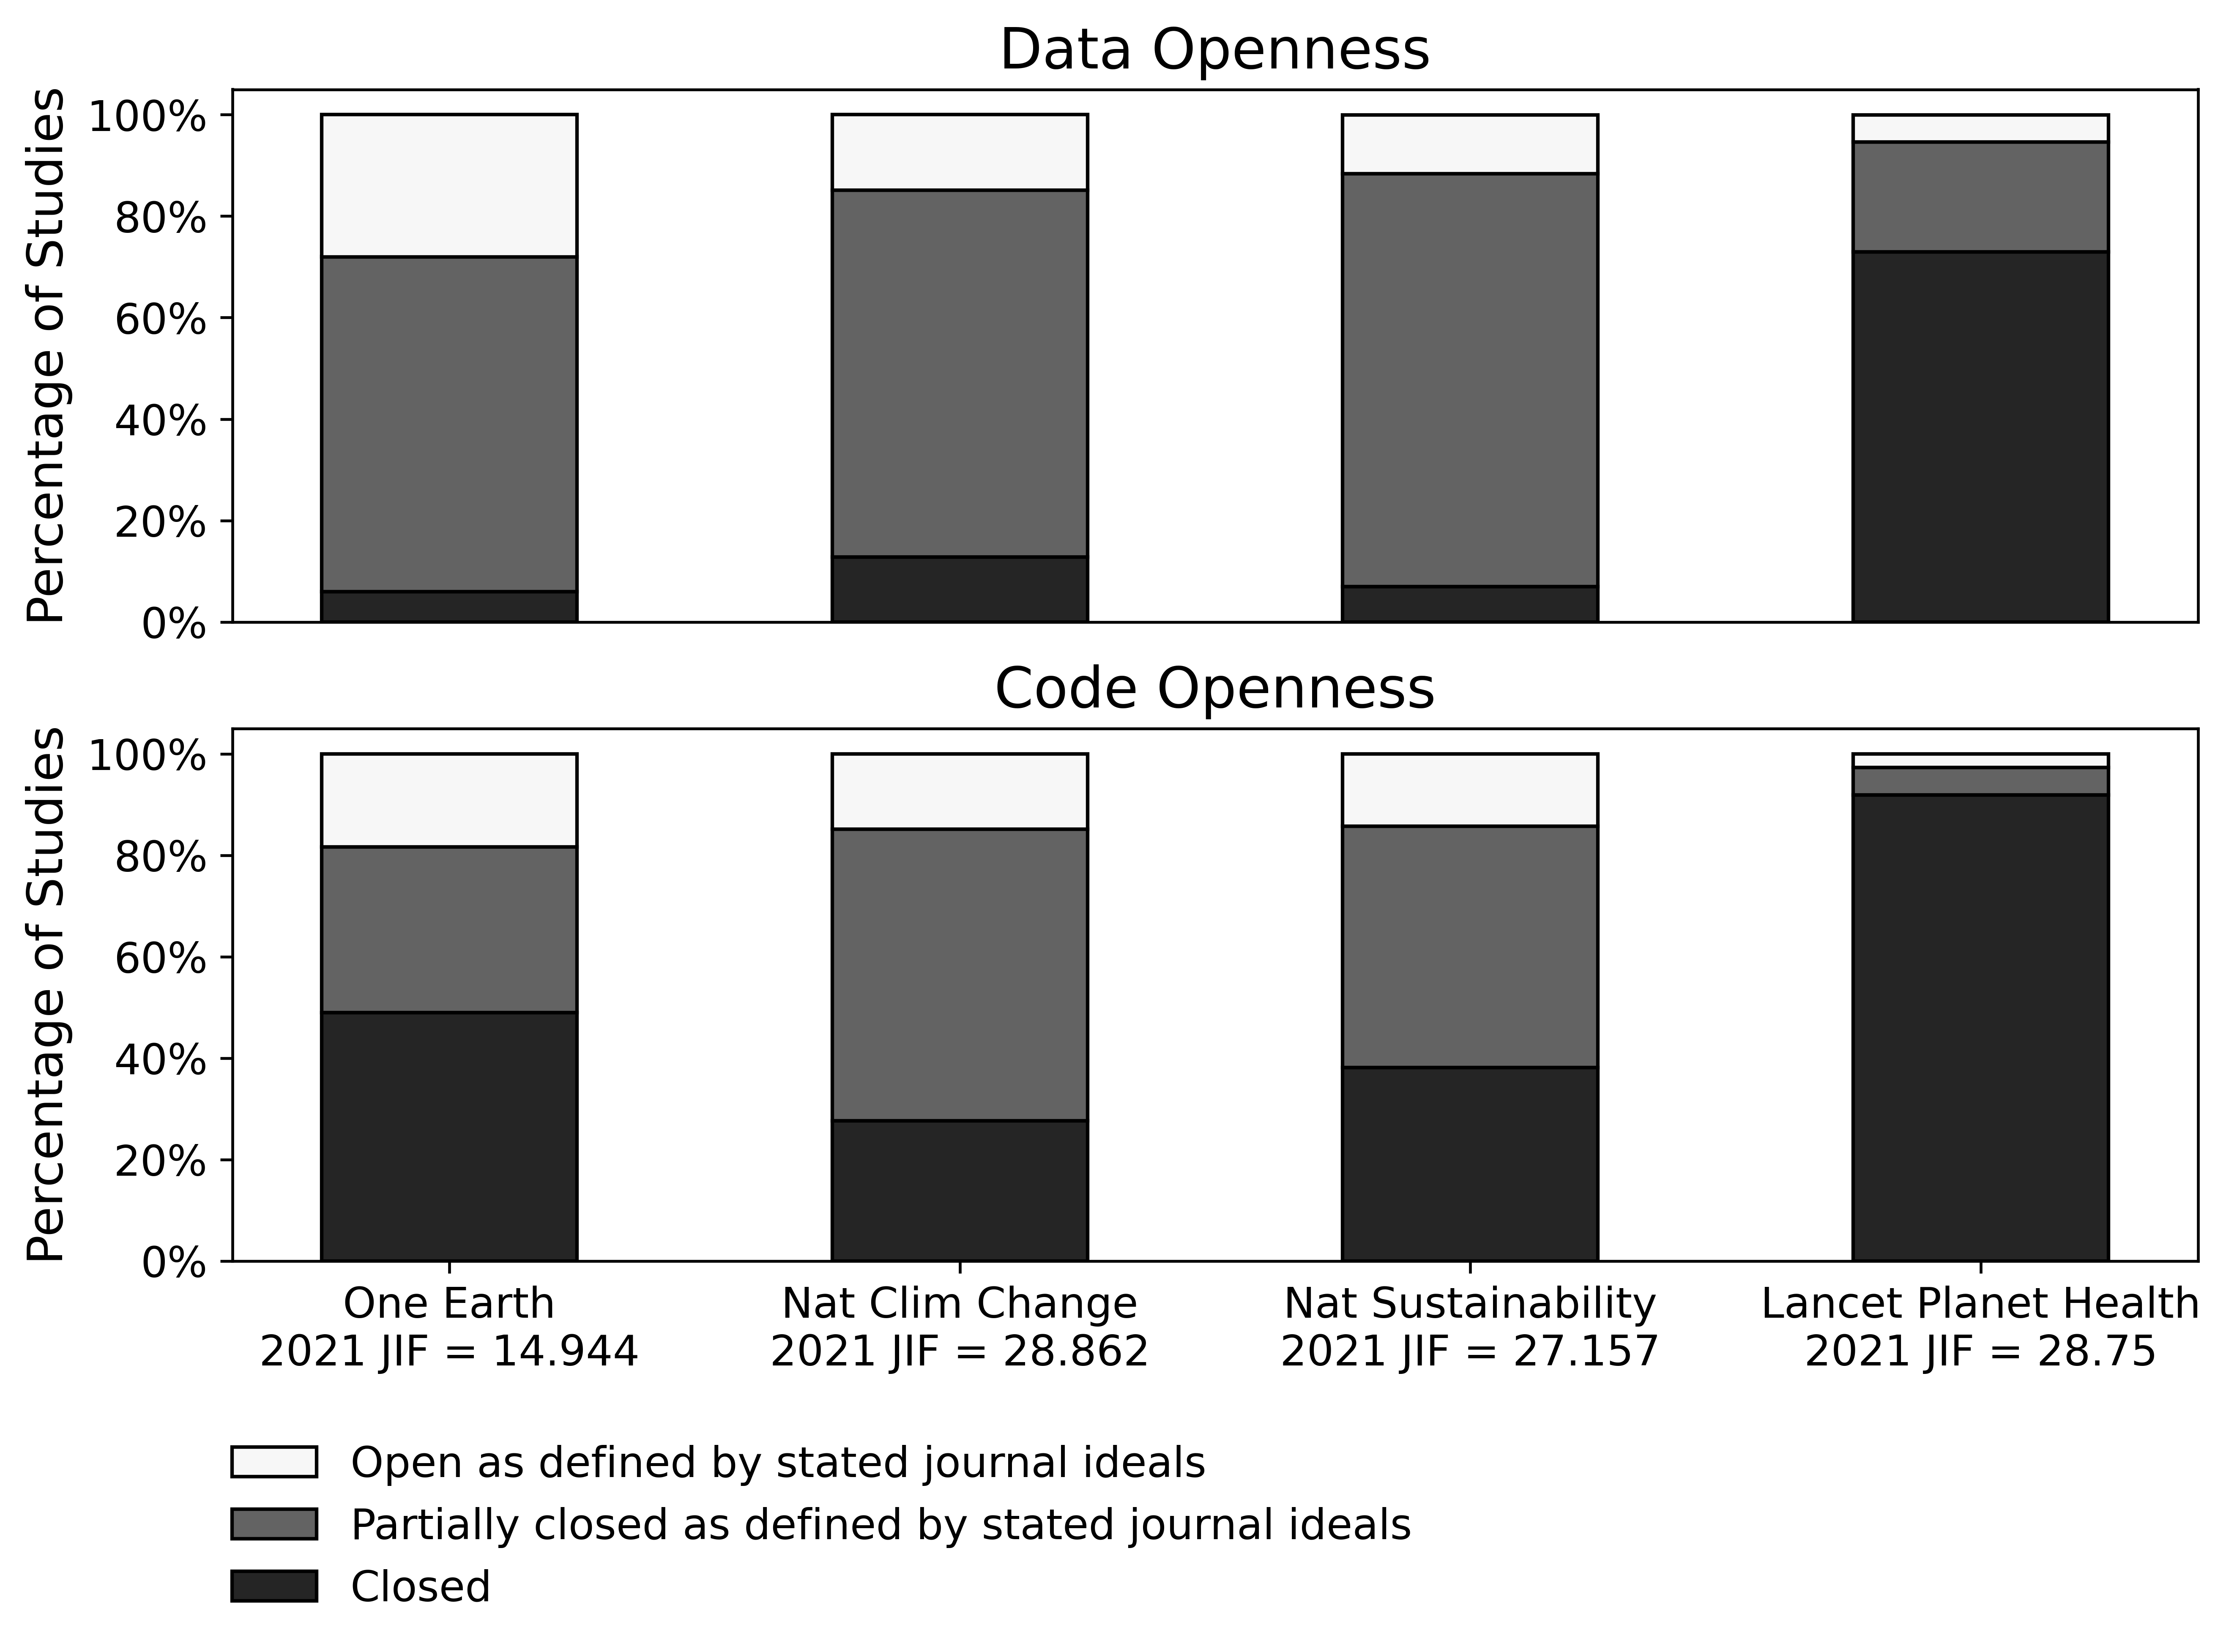

In [113]:
import matplotlib.ticker as mtick
# 2 panel stacked bar plots
# Based on this code: 
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html

# Left panel: closed data, some data, open data
# Right panel: closed code, some code, open code

# X-axis is journal names
# Sort left to right by impact factor

# Y-axis is # of papers

# Use sequential scheme for colors
# https://colorbrewer2.org/#type=sequential&scheme=Greys&n=5


journals = (
    "One Earth\n2021 JIF = 14.944",
    "Nat Clim Change\n2021 JIF = 28.862",
    "Nat Sustainability\n2021 JIF = 27.157",
    "Lancet Planet Health\n2021 JIF = 28.75",
)
data_openness = {
    "Closed": closed_data_p,
    "Partially closed as defined by stated journal ideals": some_data_p,
    "Open as defined by stated journal ideals": complete_data_p,
}
code_openness = {
    "Closed": closed_code_p,
    "Partially closed as defined by stated journal ideals": some_code_p,
    "Open as defined by stated journal ideals": complete_code_p,
}
colors = {
    "Closed": "#252525",
    "Partially closed as defined by stated journal ideals": "#636363",
    "Open as defined by stated journal ideals": "#f7f7f7"
}
width = 0.5

fig, ax = plt.subplots(figsize=(10, 6), nrows=2, 
                       sharex=True, dpi=600)

for i in range(2):
    bottom = np.zeros(4)
    openness = data_openness if i == 0 else code_openness
    for ind, count in openness.items():
        p = ax[i].bar(journals, count, width,
                      label=ind,
                      bottom=bottom,
                      edgecolor='black',
                      color=colors[ind])
        bottom += count

ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Percentage of Studies', size=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Percentage of Studies', size=14)
ax[0].tick_params(axis='x', which='both',
                  bottom=False)

ax[0].set_title('Data Openness', size=16)
ax[1].set_title('Code Openness', size=16)

ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

handles, labels = ax[1].get_legend_handles_labels()

ax[1].legend(reversed(handles),
             reversed(labels),
             loc='center',
             bbox_to_anchor=(0.3, -0.5),
             fancybox=False,
             shadow=False,
             frameon=False,
             fontsize='large',
             ncol=1)

fig.savefig(join(ROOT_DIR, 'fig', 'fig1.png'),
            dpi=600,
            bbox_inches='tight') 